In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression
import tensorflow as tf

hdf5 is not supported on this machine (please install/reinstall h5py for optimal experience)
curses is not supported on this machine (please install/reinstall curses for an optimal experience)
Scipy not supported!


In [3]:
TRAIN_DIR = "./train"

In [4]:
def convert_to_one_hot_label(img_name):
    label = img_name.split(".")[0]
    return [1, 0] if label == "cat" else [0, 1]

In [5]:
assert convert_to_one_hot_label("cat.1234.jpg") == [1, 0]
assert convert_to_one_hot_label("dog.1234.jpg") == [0, 1]

In [6]:
IMG_SIZE = 64

In [7]:
def create_train_data():
    train_data = []
    for img_name in tqdm(os.listdir(TRAIN_DIR)):
        one_hot_label = convert_to_one_hot_label(img_name)
        path = os.path.join(TRAIN_DIR, img_name)
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        train_data.append([img, np.array(one_hot_label)])
    np.random.shuffle(train_data)
    np.save("train_data_64.npy", train_data)
    return train_data

In [8]:
def create_test_data():
    test_data = []
    for img_name in tqdm(os.listdir(TEST_DIR)):
        img_num = img_name.split(".")[0]
        path = os.path.join(TEST_DIR, img_name)
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        test_data.append([img, img_num])
    np.random.shuffle(test_data)
    np.save("test_data_64.npy", test_data)
    return train_data

In [9]:
def load_data():
    if os.path.exists("train_data_64.npy"):
        print("load train data")
        train_data = np.load("train_data_64.npy")
    else:
        print("create train data")
        train_data = create_train_data()
        
    if os.path.exists("test_data_64.npy"):
        print("load test data")
        test_data = np.load("test_data_64.npy")
    else:
        print("create test data")
        test_data = create_test_data()
        
    return train_data, test_data

In [10]:
train_data, test_data = load_data()

load train data
load test data


## Split dataset

In [18]:
X_train = train_data[:-1000, 0]
y_train = train_data[:-1000, 1]

X_test = train_data[-1000:, 0]
y_test = train_data[-1000:, 1]
X_train.shape
X_test.shape

(24000,)

(1000,)

In [19]:
X_train = np.array([i for i in X_train]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_train = np.array([i for i in y_train])
X_train.shape
y_train.shape

(24000, 64, 64, 1)

(24000, 2)

In [20]:
X_test = np.array([i for i in X_test]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_test = np.array([i for i in y_test])
X_test.shape
y_test.shape

(1000, 64, 64, 1)

(1000, 2)

## Train model

In [21]:
LR = 0.0003
MODEL_NAME = "catdog-{}-{}.model".format(LR, "full-fit-2")

tf.reset_default_graph()

net = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name="input")
net = conv_2d(net, 16, 7, activation="relu")
net = conv_2d(net, 32, 5, activation="relu")
net = conv_2d(net, 64, 3, activation="relu")
net = max_pool_2d(net, 5)

net = conv_2d(net, 16, 7, activation="relu")
net = conv_2d(net, 32, 5, activation="relu")
net = conv_2d(net, 64, 3, activation="relu")
net = max_pool_2d(net, 5)

net = conv_2d(net, 16, 5, activation="relu")
net = conv_2d(net, 32, 5, activation="relu")
net = conv_2d(net, 64, 5, activation="relu")
net = max_pool_2d(net, 2)

net = conv_2d(net, 16, 3, activation="relu")
net = conv_2d(net, 32, 3, activation="relu")
net = conv_2d(net, 64, 3, activation="relu")
net = max_pool_2d(net, 2)

net = fully_connected(net, 1024, activation="relu")
net = dropout(net, 0.6)

net = fully_connected(net, 2, activation="softmax")
net = regression(
    net, 
    optimizer="adam", 
    learning_rate=LR, 
    loss="categorical_crossentropy",
    name="targets"
)

model = tflearn.DNN(net, tensorboard_dir="log")

model.fit(
    {"input": X_train},
    {"targets": y_train},
    n_epoch=9,
    validation_set=(
        {"input": X_test},
        {"targets": y_test}
    ),
    snapshot_step=500,
    show_metric=True,
    run_id=MODEL_NAME
)

Training Step: 3374  | total loss: 0.20491 | time: 74.039s
| Adam | epoch: 009 | loss: 0.20491 - acc: 0.9106 -- iter: 23936/24000
Training Step: 3375  | total loss: 0.20051 | time: 75.468s
| Adam | epoch: 009 | loss: 0.20051 - acc: 0.9149 | val_loss: 0.39684 - val_acc: 0.8570 -- iter: 24000/24000
--


In [22]:
model.save("model/"+MODEL_NAME)

INFO:tensorflow:C:\Users\WinterJ\Documents\GitHub\python\Code_Study\Machine_Learning\Cat_Dog\model\catdog-0.0003-full-fit-2.model is not in all_model_checkpoint_paths. Manually adding it.


## Check by image

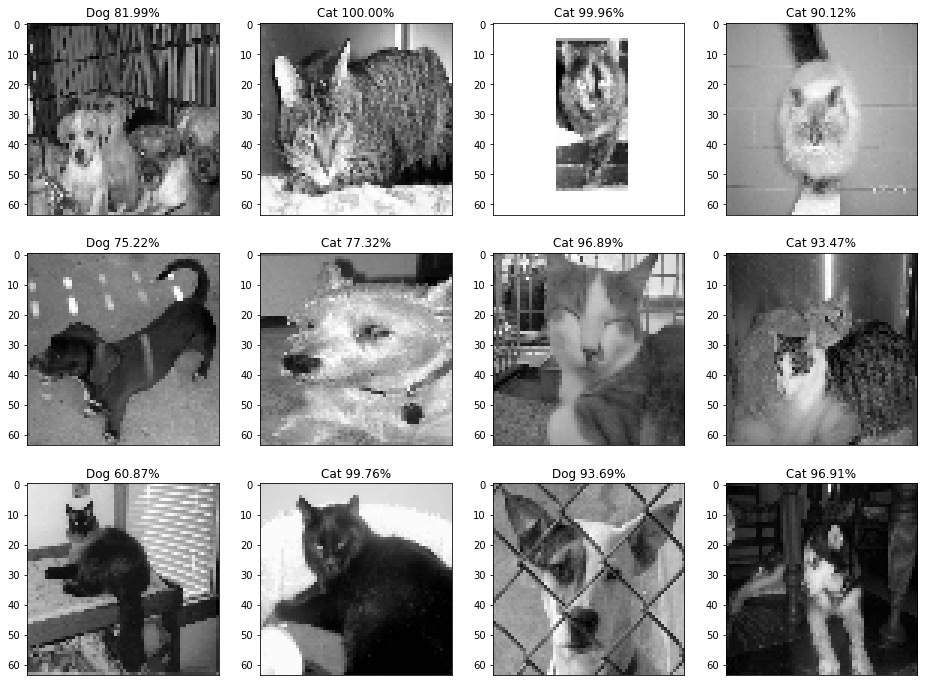

In [24]:
fig = plt.figure(figsize=(16, 12))
for num, data in enumerate(test_data[np.random.choice(range(0, 12500), 12)], 1):
    img_num = data[1]
    img_data = data[0]
    
    subplot = fig.add_subplot(3, 4, num)
    img = img_data.reshape(IMG_SIZE, IMG_SIZE, 1)
    predict = model.predict([img])[0]
    
    if np.argmax(predict) == 1:
        label = "Dog {:.2f}%".format(float(max(predict)) * 100)
    else:
        label = "Cat {:.2f}%".format(float(max(predict)) * 100)
        
    subplot.imshow(img_data, cmap="gray")
    plt.title(label)
    subplot.axes.get_xaxis().set_visible(False)
    subplot.axes.get_xaxis().set_visible(False)
plt.show();

## Make submission file

In [ ]:
with open("submission_3.csv", "w") as fp:
    fp.write("id,label\n")
    string = ""
    for data in tqdm(test_data):
        img_num = data[1]
        img_data = data[0]
        img = img_data.reshape(IMG_SIZE, IMG_SIZE, 1)
        model_out = model.predict([img])[0]
        string += "{},{}\n".format(img_num, model_out[1])
    fp.write(string)